In [53]:
import numpy as np
import pylab as plt
from astropy.cosmology import FlatLambdaCDM

import sys
sys.path.append('../scripts')
import mlp_jax as mlp

from sklearn.preprocessing import StandardScaler
from jax import numpy as jnp
from scipy import stats
from matplotlib.lines import Line2D
from matplotlib.patches import Patch


In [54]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
lines = ["OII_DOUBLET", "HGAMMA", "HBETA", "OIII_4959", "OIII_5007", "NII_6548",\
         "HALPHA", "NII_6584", "SII_6716", "SII_6731"]
lines_names = [r'[OII] $\lambda3727 + \lambda3729$', r'$H\gamma$ $\lambda$4342', r'$H\beta$ $\lambda$4863', r'[OIII] $\lambda$4969', '[OIII] $\lambda$5007', \
               '[NII] $\lambda$6548', r'$H\alpha$ $\lambda$6564', '[NII] $\lambda$6584', '[SII] $\lambda$6716', '[SII] $\lambda$6731']
# Load data. These are in lists because for each emission line the data set is slightly different (e.g. different number of objects)
obs_ews = [] # Equivalent widths
obs_ivars_ews = [] # Inverse variances on EWs
fluxes = [] # Fluxes
colors = []
luminosities = []
N = 13
flux_waves = np.zeros(N-1)
flux_waves[0] = 3400 + (7000-3400)/(2*(N-1))
for i in range(1,N-1):
    flux_waves[i] = flux_waves[i-1] + (7000-3400)/(N-1)
ind = np.searchsorted(flux_waves, 6000)
for l in range(len(lines)):
    obs_ews.append(np.load('../data/ews/sv3_obs_ews_' +lines[l]+ '.npz')['arr_0'])
    obs_ivars_ews.append(np.load('../data/ews/sv3_ew_ivars_' +lines[l]+ '.npz')['arr_0'])
    fluxes.append(np.load('../data/fluxes/sv3_fluxes_masked_' +lines[l]+ '.npz')['arr_0'])
    z = np.load('../data/redshifts/sv3_redshifts_' +lines[l]+ '.npz')['arr_0']
    # calculate colors from fluxes
    colors.append(np.zeros((fluxes[l].shape[0], fluxes[l].shape[1]-1)))
    for i in range(N-2):
        colors[l][:,i] = np.log10(fluxes[l][:,i+1]/fluxes[l][:,i])
    
    # calculate luminosity
    luminosities.append(np.log10(fluxes[l][:,ind]*(1+z)*(cosmo.luminosity_distance(z).value)**2))

In [55]:
# Load the model parameters and predict arcsinh(EWs)

pred_ews = []
pred_ews_noisy = []
dense_layer_sizes = [64, 128, 64]

for l in range(len(lines)):
    params_b_file = np.load('../models/params_b_raw_masked_selection4_line' +lines[l]+ '_bins13_ML81.npz')
    params_w_file = np.load('../models/params_w_raw_masked_selection4_line' +lines[l]+ '_bins13_ML81.npz')
    params_b = []
    params_w = []
    params = []
    for i in range(len(params_b_file)):
        params.append([params_w_file['arr_{}'.format(i)],params_b_file['arr_{}'.format(i)]])

    scaler = StandardScaler()
    colors[l] = scaler.fit_transform(colors[l])
    scaler = StandardScaler()
    luminosities[l] = scaler.fit_transform(luminosities[l].reshape(-1,1))
    features = np.concatenate((colors[l], luminosities[l]), axis=1)
    pred_ews.append(mlp.batched_prediction(params, jnp.array(features)))

    # scale back to linear 
    pred_ews[l] = np.sinh(pred_ews[l])
    pred_ews_noisy.append(np.random.normal(pred_ews[l], np.sqrt(1/obs_ivars_ews[l])))

    np.savez_compressed('../data/ews/sv3_pred_ews_' +lines[l]+ '.npz', pred_ews[l])
    


Text(0.05, 0.5, 'Counts')

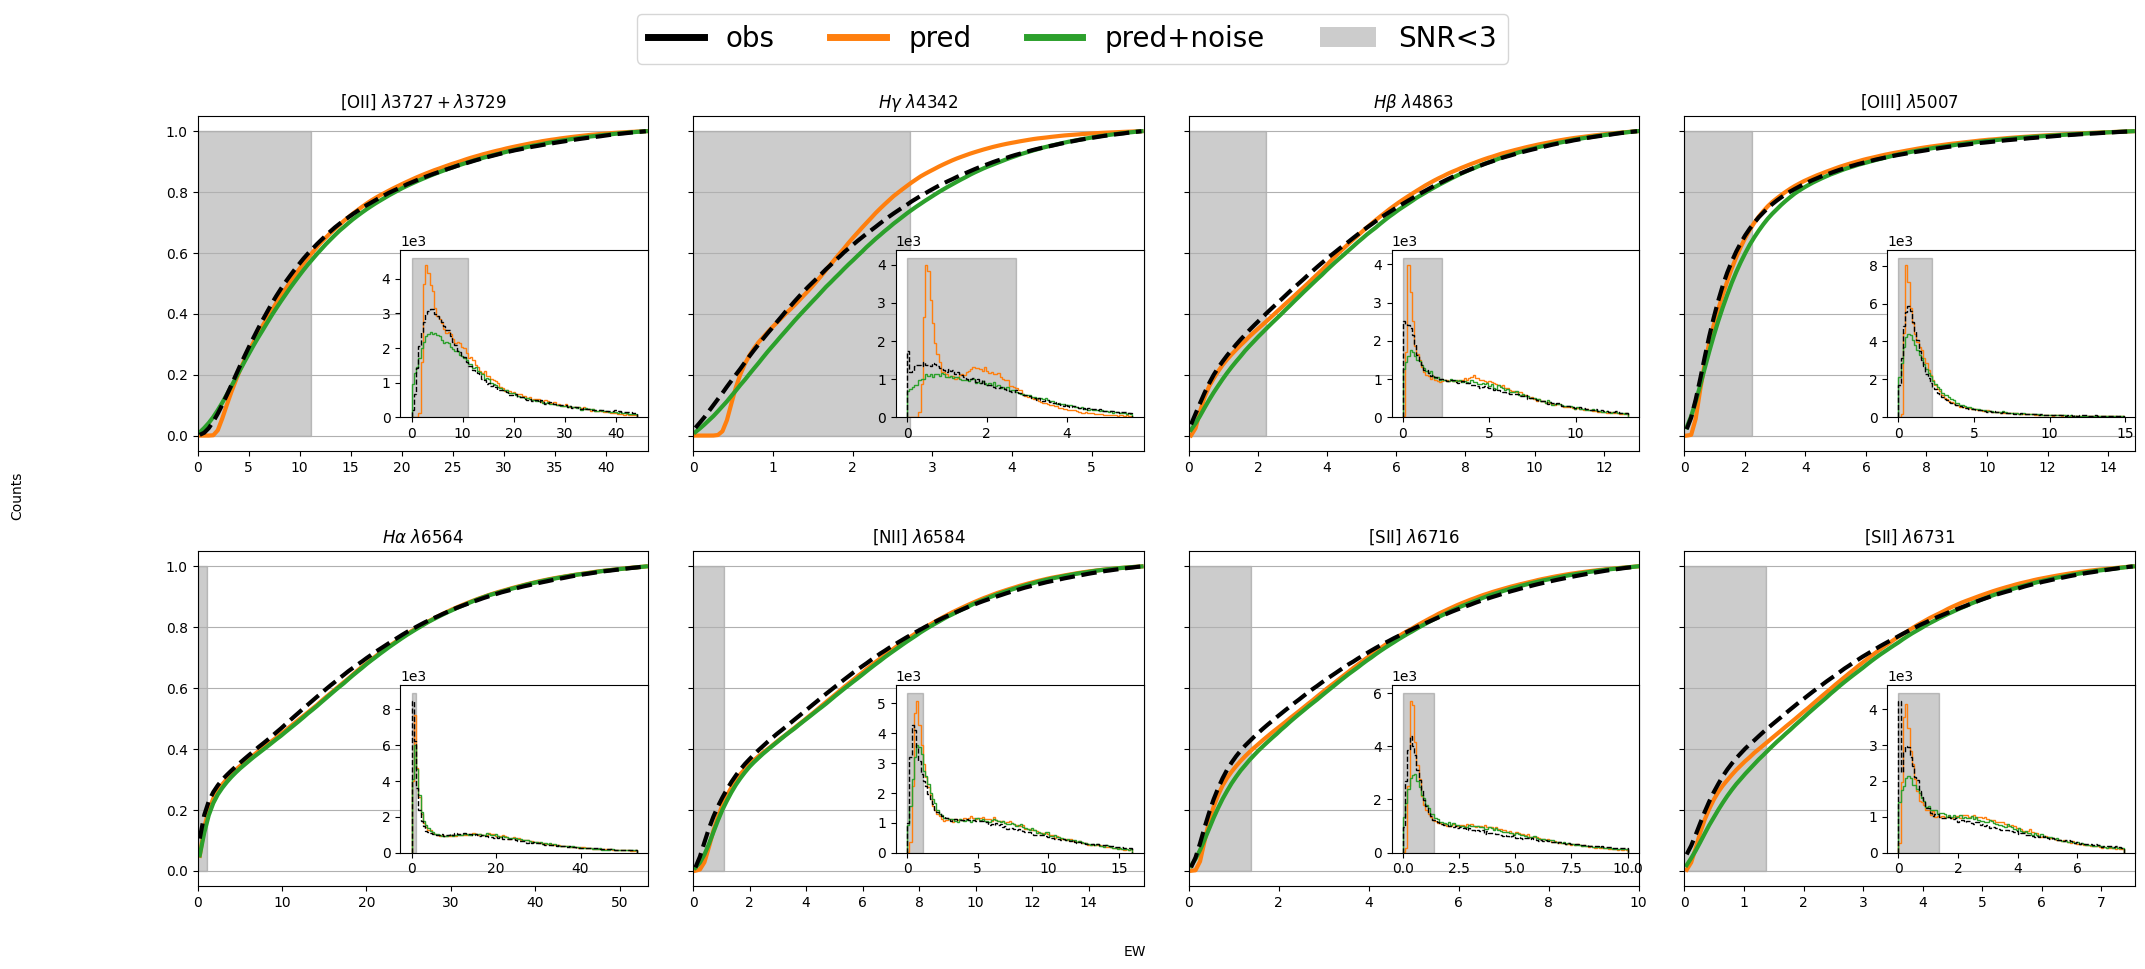

In [56]:
ll = [[0,1,2,4],[6,7,8,9]]
n_bins = 100
lw = 1

fig, ax = plt.subplots(figsize=(25,10), nrows=2, ncols=4, sharey=True)
fig.subplots_adjust(wspace=0.1, hspace=0.3)
for i in range(2):
    for j in range(4):
        l = ll[i][j]
        spearman = stats.spearmanr(obs_ews[l], pred_ews[l])[0]
        nmad = 1.48*np.median(np.abs(obs_ews[l]-pred_ews[l]))
        bias = np.median(pred_ews[l]/obs_ews[l])
        
        # ax[i,j].hist(np.log10(obs_ews[l]), bins=100, range=(-2,2.3), color='k', alpha=1, histtype='step', label='obs')#, label=f's={spearman:.2f}')
        # ax[i,j].hist(np.log10(pred_ews[l]), bins=100, range=(-2,2.3), color='tab:orange', alpha=1, histtype='step', label='pred')#, label=f'nmad={nmad:.2f}')
        # ax[i,j].hist(np.log10(pred_ews_noisy[l]), bins=100, range=(-2,2.3), color='tab:green', alpha=1, histtype='step', label='pred noisy')#, label=f'bias={bias:.2f}')
        inset_ax = ax[i,j].inset_axes([0.45, 0.1, 0.55, 0.5])

        hist_fit = inset_ax.hist(pred_ews[l], bins=n_bins, range=(0,np.quantile(obs_ews[l],0.95)), color='tab:orange', alpha=1, histtype='step', label='pred', linewidth=lw)#, label=f'nmad={nmad:.2f}')
        hist_fit_noisy = inset_ax.hist(pred_ews_noisy[l], bins=n_bins, range=(0,np.quantile(obs_ews[l],0.95)), color='tab:green', alpha=1, histtype='step', label='pred noisy', linewidth=lw)#, label=f'bias={bias:.2f}')            #ax[i,j].legend([f's={spearman:.2f}', f'nmad={nmad:.2f}', f'bias={bias:.2f}'])
        hist_obs = inset_ax.hist(obs_ews[l], bins=n_bins, range=(0,np.quantile(obs_ews[l],0.95)), color='k', alpha=1, histtype='step', label='obs', linewidth=lw, linestyle='dashed')#, label=f's={spearman:.2f}')
        #ax[i,j].annotate(f's={spearman:.2f}\nn={nmad:.2f}\nf_b={bias:.2f}', xy=(0.1,0.7), xycoords='axes fraction')
        ax[i,j].set_title(lines_names[l])
        inset_ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        snr = stats.binned_statistic(obs_ews[l], obs_ews[l]*np.sqrt(obs_ivars_ews[l]), bins=n_bins, range=np.quantile(obs_ews[l],(0.0,0.95)), statistic='mean')
        bin_centers = 0.5*(snr[1][1:]+snr[1][:-1])
        snr_lim = np.interp(3, snr[0], bin_centers)
        ax[i,j].fill_between([0, snr_lim], 0, 1, color='black', alpha=0.2)
        inset_ax.fill_between([0, snr_lim], 0, inset_ax.get_ylim()[1], color='black', alpha=0.2)



        obs_cumsum = np.cumsum(hist_obs[0])
        fit_cumsum = np.cumsum(hist_fit[0])
        fit_noisy_cumsum = np.cumsum(hist_fit_noisy[0])

        ax[i,j].plot(0.5*(hist_fit[1][:-1]+hist_fit[1][1:]), fit_cumsum/fit_cumsum[-1], color='tab:orange', lw=3)
        ax[i,j].plot(0.5*(hist_fit_noisy[1][:-1]+hist_fit_noisy[1][1:]), fit_noisy_cumsum/fit_noisy_cumsum[-1], color='tab:green', lw=3)
        ax[i,j].plot(0.5*(hist_obs[1][:-1]+hist_obs[1][1:]), obs_cumsum/obs_cumsum[-1], color='k', linestyle='dashed', lw=3)

        # inset_ax.plot(fit_sorted, fit_cumsum/fit_cumsum[-1], color='tab:orange')
        # inset_ax.plot(fit_noisy_sorted, fit_noisy_cumsum/fit_noisy_cumsum[-1], color='tab:green')
        ax[i,j].set_xlim(0, np.quantile(obs_ews[l],(0.01,0.95))[1])
        ax[i,j].grid(axis='y')
#plt.tight_layout()
#ax[1,1].legend()


legend_elements = [Line2D([0],[0], color='k', alpha=1, linewidth=5, ls='-', label='obs'),
                   Line2D([0],[0], color='tab:orange', alpha=1, linewidth=5, ls='-', label='pred'),
                   Line2D([0],[0], color='tab:green', linewidth=5, ls='-', label='pred+noise'),
                   Patch(facecolor='black', alpha=0.2, label='SNR<3')]


leg = fig.legend(handles=legend_elements, loc='upper center', prop={'size': 20}, ncol=len(legend_elements))

fig.text(0.5, 0.04, r'EW', ha='center')
fig.text(0.05, 0.5, r'Counts', va='center', rotation='vertical')
#plt.tight_layout()

